In [1]:
import pennylane as qml
from pennylane import numpy as np

In [27]:
import math
import pennylane as qml
from pennylane import numpy as np
from scipy.linalg import expm

# Step 1: Construct TFIM matrix H
n = 4
coeffs, ops = [], []
for i in range(n - 1):
    coeffs.append(-1.0)
    ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
for i in range(n):
    coeffs.append(-1.0)
    ops.append(qml.PauliX(i))
H_tfim = qml.Hamiltonian(coeffs, ops)
H_mat = qml.matrix(H_tfim)

# Step 2: LCU form of cos^{2m}(H)
m = 4
k_vals = np.arange(-m, m + 1)
alpha_k = 2**(-2 * m) * np.array([math.comb(2 * m, m + k) for k in k_vals])
U_k = [expm(2j * k * H_mat) for k in k_vals]
U_k_ops = [qml.Hermitian(U.real, wires=range(n)) for U in U_k]  # use Hermitian(real) approximation
cos2m_op = qml.dot(alpha_k, U_k_ops)

# Step 3: Define QPE circuit
n_control = int(np.ceil(np.log2(len(alpha_k))))
control_wires = [n + i for i in range(n_control)]
aux_wire = n + n_control

@qml.qnode(qml.device("default.qubit", wires=aux_wire + 1))
def circuit():
    # Prepare nontrivial input eigenstate
    for i in range(n):
        qml.Hadamard(i)

    # QPE via Qubitization
    measurements = qml.iterative_qpe(
        qml.Qubitization(cos2m_op, control=control_wires),
        aux_wire=aux_wire,
        iters=4
    )
    return qml.probs(op=measurements)

# Step 4: Run & postprocess
output = circuit()
index = np.argmax(output)
theta = 2 * np.pi * index / 2**3
alpha = sum(alpha_k)

eigenvalue = alpha * np.cos(theta)

print("θ index:", index)
print("cos(θ) ≈", np.cos(theta))
print("Estimated eigenvalue ≈", eigenvalue)


θ index: 4
cos(θ) ≈ -1.0
Estimated eigenvalue ≈ -1.0


In [3]:
import pennylane as qml

H = -0.4 * qml.Z(0) + 0.3 * qml.Z(1) + 0.4 * qml.Z(0) @ qml.Z(1)

#print(np.linalg.eigvalsh(qml.matrix(H).real)[0])
control_wires = [2, 3]
estimation_wires = [4, 5, 6, 7, 8, 9]

dev = qml.device("default.qubit")


@qml.qnode(dev)
def circuit():
    # Initialize the eigenstate |11⟩
    # for wire in [0, 1]:
    #     qml.X(wire)

    # Apply QPE with the qubitization operator
    qml.QuantumPhaseEstimation(
        qml.Qubitization(H, control_wires), estimation_wires=estimation_wires
    )

    return qml.probs(wires=estimation_wires)

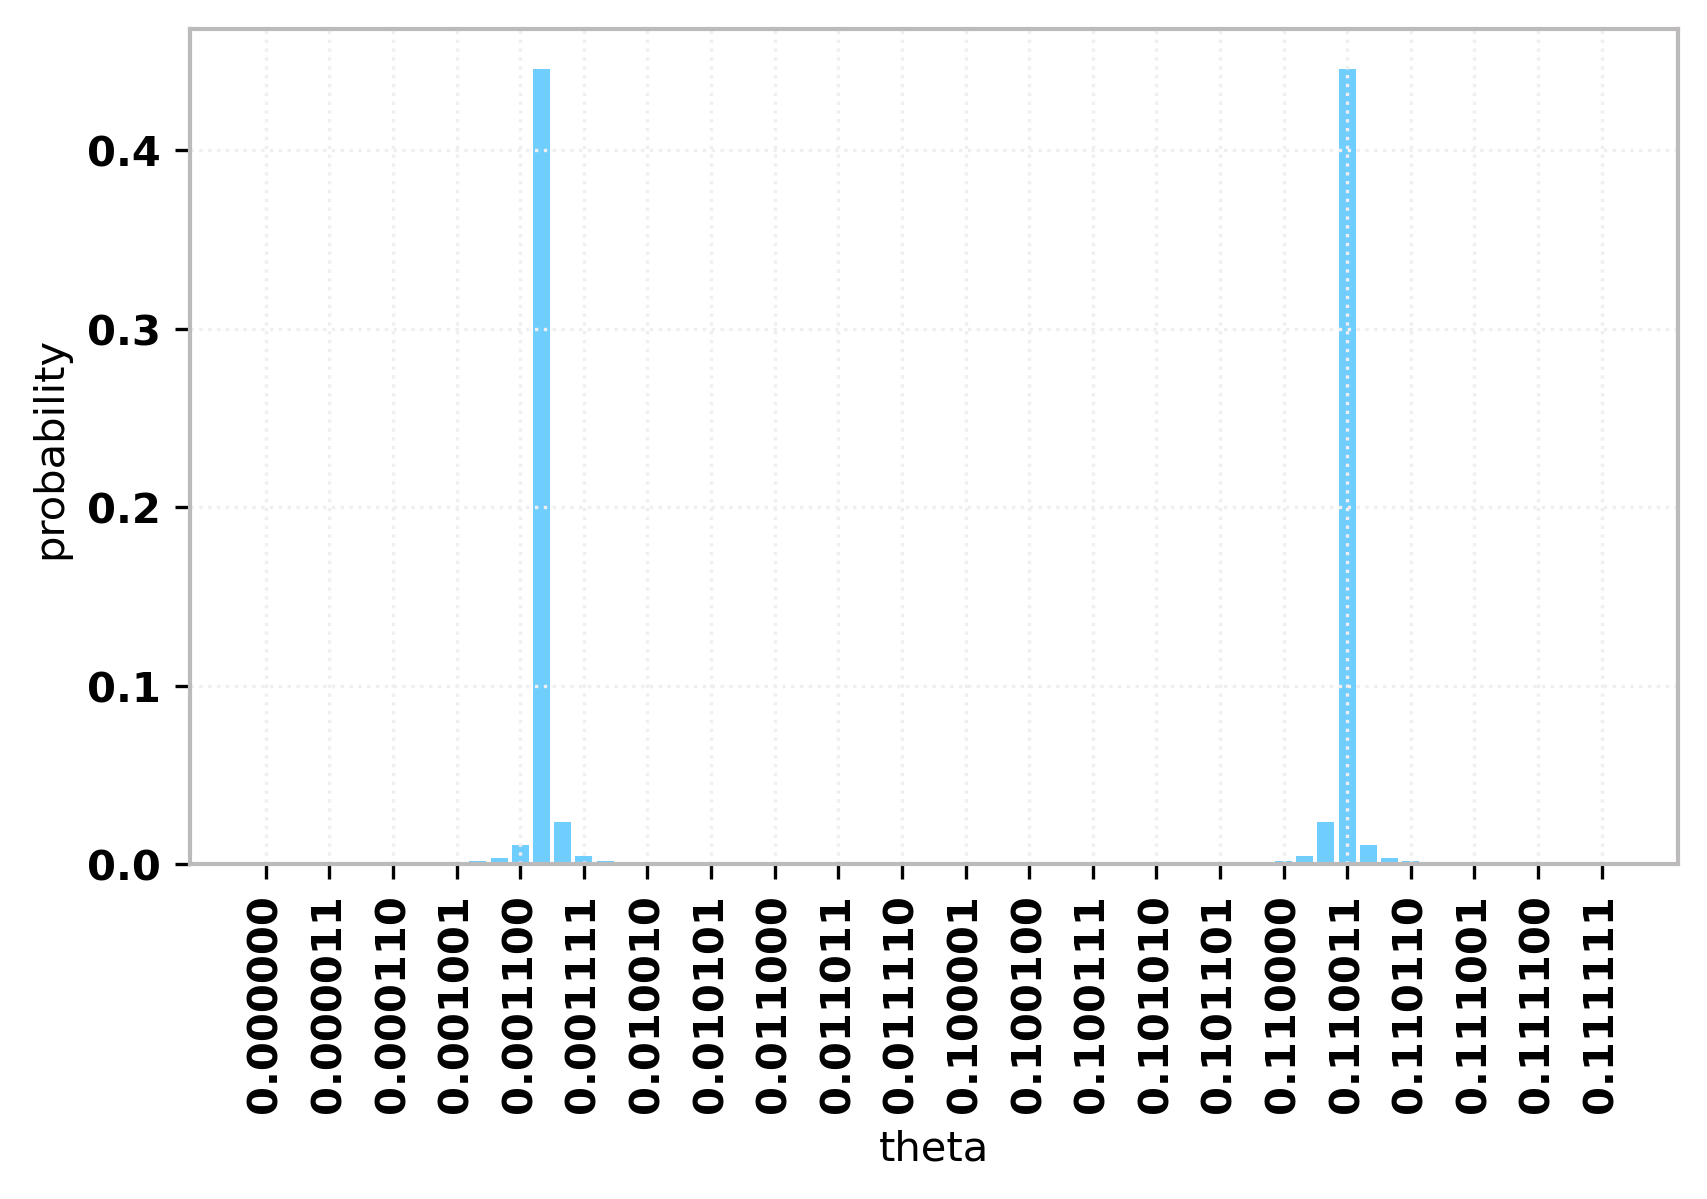

In [4]:
import matplotlib.pyplot as plt

plt.style.use("pennylane.drawer.plot")

results = circuit()

bit_strings = [f"0.{x:0{len(estimation_wires)}b}" for x in range(len(results))]

plt.bar(bit_strings, results)
plt.xlabel("theta")
plt.ylabel("probability")
plt.xticks(range(0, len(results), 3), bit_strings[::3], rotation="vertical")

plt.subplots_adjust(bottom=0.3)
plt.show()

In [5]:
import numpy as np

lambda_ = sum([abs(coeff) for coeff in H.terms()[0]])

# Simplification by estimating theta with the peak value
print("E = ", lambda_ * np.cos(2 * np.pi * np.argmax(results) / 2 ** (len(estimation_wires))))

E =  0.3193131449799086


In [6]:
import math
import pennylane as qml
from pennylane import numpy as np

# 1. TFIM Hamiltonian: 4 qubits, J=1, h=1
n = 4
J, h = 1.0, 1.0
coeffs, ops = [], []
for i in range(n - 1):
    coeffs.append(-J)
    ops.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
for i in range(n):
    coeffs.append(-h)
    ops.append(qml.PauliX(i))

H = qml.Hamiltonian(coeffs, ops)

# 2. Wire assignment
n_anc = int(np.ceil(np.log2(len(coeffs))))  # enough for SELECT(V)
phase_wire = n + n_anc                      # phase kickback wire
total_wires = list(range(phase_wire + 1))   # full system wires
anc_wires = list(range(n, n + n_anc))       # ancilla for SELECT
data_wires = list(range(n))                 # data qubits

dev = qml.device("default.qubit", wires=total_wires)

# 3. Qubitization + iterative QPE
@qml.qnode(dev)
def qubitization_qpe():
    return qml.iterative_qpe(
    qml.Qubitization(H, control=anc_wires),
    aux_wire=phase_wire,
    iters=6
)



# 4. Run circuit and compute energy
probs = qubitization_qpe()
theta_est = 2 * np.pi * np.argmax(probs) / len(probs)
alpha = sum(abs(c) for c in coeffs)
ground_energy = alpha * np.cos(theta_est)

print("估计基态能量 ≈", ground_energy)


QuantumFunctionError: A quantum function must return either a single measurement, or a nonempty sequence of measurements.

In [21]:
phase_wire

7

In [22]:
H

(
    -1.0 * (Z(0) @ Z(1))
  + -1.0 * (Z(1) @ Z(2))
  + -1.0 * (Z(2) @ Z(3))
  + -1.0 * X(0)
  + -1.0 * X(1)
  + -1.0 * X(2)
  + -1.0 * X(3)
)

In [23]:
n_anc

3